In [49]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img
import cv2
import os

In [222]:
image_exts = ['jpeg','jpg','png']  # Define the list of acceptable image extensions
data_dir = 'dataset/Image_FER2013_AffectNet_Dataset/'

In [134]:
# # Walk through all folders and files
# for root, dirs, files in os.walk(data_dir):
#     for file in files:
#         file_path = os.path.join(root, file)
#         file_ext = file.split('.')[-1].lower()

#         # Check if it's a valid image file extension
#         if file_ext not in image_exts:
#             print(f"[EXT ERROR] Not an image: {file_path}")
#             os.remove(file_path)  # Optional: remove invalid extension files
#             continue

#         # Try reading the image
#         try:
#             img = cv2.imread(file_path)
#             if img is None:
#                 print(f"[READ ERROR] Unreadable image: {file_path}")
#                 os.remove(file_path)  # Optional: remove unreadable images
#         except Exception as e:
#             print(f"[EXCEPTION] Error reading {file_path}: {e}")
#             os.remove(file_path)  # Optional: remove problematic files

In [218]:
def count_files_in_subdirs(directory, set_name):
    counts = {}
    valid_exts = ('.jpg', '.jpeg', '.png')

    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            total_files = 0
            # print(f"\n📁 Folder: {item}")
            for root, _, files in os.walk(item_path):
                for f in files:
                    file_path = os.path.join(root, f)
                    if f.lower().endswith(valid_exts) and os.path.isfile(file_path):
                        # print(f"  - {f}")  # 🖼️ Show image name
                        total_files += 1
            counts[item] = total_files
            # print(f"✅ {item_path} ➜ {total_files} images")

    df = pd.DataFrame(counts, index=[set_name])
    return df

In [52]:
image_dataset = count_files_in_subdirs(data_dir,"image_dataset")
image_dataset

,anger,disgust,fear,happy,neutral,sad,surprise
image_dataset,15719,15422,15696,16000,15976,15860,15691


<Axes: >

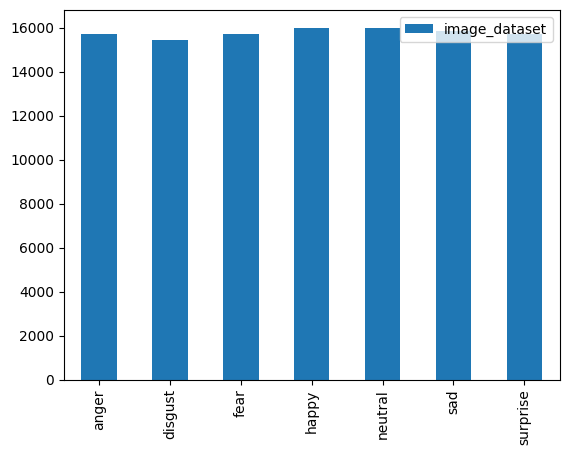

In [53]:
image_dataset.transpose().plot(kind='bar')

In [222]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

In [223]:
# # Set up augmentation generator
# augmentor = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.12,
#     height_shift_range=0.13,
#     zoom_range=0.15,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

In [224]:
# target_count = 16000
# image_size = (48, 48)

In [225]:
# for class_name in os.listdir(data_dir):
#     class_dir = os.path.join(data_dir, class_name)
#     if not os.path.isdir(class_dir):
#         continue

#     image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
#     current_count = len(image_files)

#     print(f"📁 {class_name}: {current_count} images")

#     if current_count >= target_count:
#         continue  # already balanced

#     needed = target_count - current_count
#     print(f"🔄 Augmenting {needed} images for '{class_name}'...")

#     idx = 0
#     while needed > 0:
#         image_path = os.path.join(class_dir, image_files[idx % current_count])
#         img = load_img(image_path, target_size=image_size, color_mode="grayscale")
#         x = img_to_array(img)
#         x = x.reshape((1,) + x.shape)

#         # Generate one batch at a time
#         for batch in augmentor.flow(x, batch_size=1, save_to_dir=class_dir, save_prefix='aug', save_format='png'):
#             needed -= 1
#             if needed <= 0:
#                 break

#         idx += 1

In [54]:
def CreateDataFrame(directory):
    image_path = []
    labels =  []
    for label in os.listdir(directory):
        for image_name in os.listdir(os.path.join(directory,label)):
            image_path.append(os.path.join(directory,label,image_name))
            labels.append(label)
    return image_path,labels

In [55]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')  # Load as grayscale
        img = np.array(img)
        img = cv2.resize(img, (48, 48))  # Resize to 48x48
        features.append(img)
    
    features = np.array(features)
    
    # Normalize pixel values to [0, 1]
    features = features.astype('float32') / 255.0

    # Add channel dimension: (48, 48, 1)
    features = features[..., np.newaxis]

    return features

In [56]:
Image_Dataset = pd.DataFrame()
Image_Dataset["image"],Image_Dataset["label"] = CreateDataFrame(data_dir)

In [58]:
mood_mapping = {"anger": 0,"disgust": 1,"fear": 2,"happy": 3,"neutral": 4,"sad": 5,"surprise": 6}

In [59]:
Image_Dataset_backup = Image_Dataset.copy()
Image_Dataset["label"] = Image_Dataset["label"].map(mood_mapping)

In [60]:
print(Image_Dataset.label.value_counts())

label
3    16000
4    15976
5    15860
0    15719
2    15696
6    15691
1    15422
Name: count, dtype: int64


In [61]:
Image_Dataset_features = extract_features(Image_Dataset["image"])
Image_Dataset_labels = Image_Dataset["label"]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110364/110364 [21:36<00:00, 85.12it/s]


In [62]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(Image_Dataset_features, Image_Dataset_labels, test_size=0.2, random_state=42)

In [63]:
# One-hot encode labels
y_train_oh = to_categorical(y_train, num_classes=7)
y_test_oh = to_categorical(y_test, num_classes=7)

In [217]:
# ────────────── 🔧 Utility Block Layer: Conv + BN + SWISH ──────────────
def conv_bn_swish(x, filters, kernel_size=3, stride=1):
    """
    Applies Conv2D → BatchNormalization → Swish Activation
    Arguments:
    - x: input tensor
    - filters: number of output channels
    - kernel_size: size of convolution window
    - stride: how much to move the window
    """
    x = layers.Conv2D(
        filters, 
        kernel_size, 
        strides=stride, 
        padding='same',
        kernel_regularizer=keras.regularizers.l2(5e-5)  # L2 regularization
    )(x)
    x = layers.BatchNormalization()(x)
    return layers.Activation('swish')(x)

# ────────────── 🔁 Residual Block Layer with Skip Connections ──────────────
def residual_block(x, filters, convs=2, stride=1, dropout_rate=0.50):
    """
    Residual block with multiple conv_bn_swish layers and a skip connection.
    Arguments:
    - x: input tensor
    - filters: number of filters in each conv layer
    - convs: number of conv_bn_swish layers in the block
    - stride: stride for the first conv layer
    - dropout_rate: dropout probability after pooling
    """
    shortcut = x  # Save input for skip connection

    # Apply convolution layers
    for i in range(convs):
        s = stride if i == 0 else 1
        x = conv_bn_swish(x, filters, stride=s)

    # Match shape of shortcut if needed (channels or stride mismatch)
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv2D(
            filters, 
            1, 
            strides=stride, 
            padding='same',
            kernel_regularizer=keras.regularizers.l2(5e-5)  # L2 regularization
        )(shortcut)

    # Add skip connection: main path + shortcut
    x = layers.Add()([x, shortcut])
    x = layers.SpatialDropout2D(dropout_rate)(x)  # 👈 Use instead of regular Dropout
    return x

# ────────────── 🧠 Full Model Builder ──────────────
def build_model(input_shape=(48, 48, 1), num_classes=7):
    """
    Builds the full CNN model with residual blocks and dense layers.
    Arguments:
    - input_shape: shape of input image (default is 48x48 grayscale)
    - num_classes: number of output categories
    - blocks: how many residual blocks to stack
    """
    inputs = layers.Input(shape=input_shape)
    x = inputs
    
    # # Define filter progression
    filter_list = [32, 64, 128, 256, 512]

    # Apply residual blocks
    for i, filters in enumerate(filter_list):
        stride = 1 if i == 0 else 2
        convs = 2 if i == 0 else 3
        x = residual_block(x, filters=filters, convs=convs, stride=stride)

    # ───── Global Average Pooling instead of Flatten ─────
    x = layers.GlobalAveragePooling2D()(x)  # Compress spatial dimensions while preserving features
    x = layers.BatchNormalization()(x)      # 🔧 Normalize pooled features
    
    # ───── Fully Connected Dense Layers ─────  
    for units in [256, 128, 64, 32]:
        x = layers.Dense(units)(x)          # Linear transformation
        x = layers.BatchNormalization()(x)  # Normalize features for stability
        x = layers.Activation('swish')(x)  
        x = layers.Dropout(0.5)(x)          # Regularize (drop 50% neurons randomly)
    
    # Output layer: one neuron per class (7 classes)
    temperature = 0.7
    outputs = layers.Lambda(lambda x: x / temperature)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = models.Model(inputs, outputs)
    return model

In [221]:
model = build_model()
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 48, 48, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_76 (Conv2D)            │ (None, 48, 48, 32)        │             320 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_76        │ (None, 48, 48, 32)        │             128 │ conv2d_76[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_72 (Activation)    │ (None, 48, 48, 32)        │               0 │ batch_normalization_76[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_77 (Conv2D)            │ (None, 48, 48, 32)        │           9,248 │ activation_72[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_77        │ (None, 48, 48, 32)        │             128 │ conv2d_77[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_73 (Activation)    │ (None, 48, 48, 32)        │               0 │ batch_normalization_77[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_78 (Conv2D)            │ (None, 48, 48, 32)        │              64 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_20 (Add)                  │ (None, 48, 48, 32)        │               0 │ activation_73[0][0],       │
│                               │                           │                 │ conv2d_78[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spatial_dropout2d_20          │ (None, 48, 48, 32)        │               0 │ add_20[0][0]               │
│ (SpatialDropout2D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_79 (Conv2D)            │ (None, 24, 24, 64)        │          18,496 │ spatial_dropout2d_20[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_78        │ (None, 24, 24, 64)        │             256 │ conv2d_79[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_74 (Activation)    │ (None, 24, 24, 64)        │               0 │ batch_normalization_78[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_80 (Conv2D)            │ (None, 24, 24, 64)        │          36,928 │ activation_74[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_79        │ (None, 24, 24, 64)        │             25

 Total params: 8,211,687 (31.33 MB)

 Trainable params: 8,203,815 (31.30 MB)

 Non-trainable params: 7,872 (30.75 KB)

In [66]:
# WarmUp + CosineDecay combined
class WarmUpCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, decay_steps, warmup_steps, alpha=0.0):
        super().__init__()
        self.initial_lr = initial_lr
        self.decay_steps = decay_steps
        self.warmup_steps = warmup_steps
        self.alpha = alpha

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        linear_increase = self.initial_lr * global_step / self.warmup_steps
        cosine_decay = 0.5 * self.initial_lr * (1 + tf.cos(np.pi * (global_step - self.warmup_steps) / (self.decay_steps - self.warmup_steps)))
        decayed = tf.where(global_step < self.warmup_steps, linear_increase, cosine_decay)
        return tf.where(global_step > self.decay_steps, self.alpha * self.initial_lr, decayed)

    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "decay_steps": self.decay_steps,
            "warmup_steps": self.warmup_steps,
            "alpha": self.alpha,
        }

In [209]:
# Assuming 50 epochs, ~5000 steps total (depends on batch size)
batch_size = 256
num_epochs = 50
steps_per_epoch = len(x_train) // batch_size
total_steps = steps_per_epoch * num_epochs
warmup_steps = 10 * steps_per_epoch  # 10 epochs

In [223]:
# 🧠 Learning Rate Schedule
lr_schedule = WarmUpCosineDecay(
    initial_lr=1e-4,  
    decay_steps=total_steps,
    warmup_steps=warmup_steps,
    alpha = 1e-6                  # Final LR floor
)

In [208]:
loss = CategoricalCrossentropy(label_smoothing=0.05)

In [70]:
class ManualSWA(tf.keras.callbacks.Callback):
    def __init__(self, start_epoch):
        super().__init__()
        self.start_epoch = start_epoch
        self.n_models = 0
        self.swa_weights = None

    def on_epoch_end(self, epoch, logs=None):
        if epoch + 1 >= self.start_epoch:
            print(f"🔁 SWA: Averaging weights at epoch {epoch + 1}")
            weights = self.model.get_weights()
            if self.swa_weights is None:
                self.swa_weights = [np.copy(w) for w in weights]
            else:
                for i in range(len(weights)):
                    self.swa_weights[i] = (self.swa_weights[i] * self.n_models + weights[i]) / (self.n_models + 1)
            self.n_models += 1

    def on_train_end(self, logs=None):
        if self.swa_weights:
            print("✅ SWA: Applying averaged weights")
            self.model.set_weights(self.swa_weights)

In [71]:
# Define base optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [72]:
# ─────── Compile ───────
model.compile(
    optimizer=optimizer,
    loss = loss,
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [73]:
# ─────── Callbacks ───────

# Stop training if val_loss doesn't improve for 3 epochs
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True, 
    verbose=1
)

# Save the model weights with best val_accuracy
checkpoint = ModelCheckpoint(
    filepath='best_emotion_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# 🧬 SWA Callback
swa_callback = ManualSWA(start_epoch=25)

In [74]:
# ───────────────────────────────
# 🚀 Train the CNN model
# ───────────────────────────────
history = model.fit(
    x_train, 
    y_train_oh,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint,swa_callback],
    verbose=2
)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.14117, saving model to best_emotion_model.keras
276/276 - 1523s - 6s/step - accuracy: 0.1447 - auc: 0.5007 - loss: 2.4863 - precision: 0.1463 - recall: 0.0186 - val_accuracy: 0.1412 - val_auc: 0.4993 - val_loss: 2.1169 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.14117
276/276 - 1519s - 6s/step - accuracy: 0.1476 - auc: 0.5066 - loss: 2.4513 - precision: 0.1564 - recall: 0.0181 - val_accuracy: 0.1389 - val_auc: 0.5091 - val_loss: 2.1162 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50

Epoch 3: val_accuracy did not improve from 0.14117
276/276 - 1585s - 6s/step - accuracy: 0.1545 - auc: 0.5165 - loss: 2.3843 - precision: 0.1688 - recall: 0.0161 - val_accuracy: 0.1386 - val_auc: 0.5177 - val_loss: 2.1063 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50

Epoch 4: val_accuracy improved from 0.14117 to 0.14474, saving model to best_emotion

In [75]:
# ────────────────────────────────────────────────────── 📊 Final Evaluation ───────────────────────────────────────────────────────

test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(x_test, y_test_oh, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")

print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Test Loss: 1.1298
Test Accuracy: 0.7030
Test Precision: 0.8530
Test Recall: 0.6011
Test AUC: 0.9402


In [76]:
import matplotlib.pyplot as plt

def plot_training_metrics(history):
    """ Plots accuracy, loss, precision, recall, and AUC over training epochs. Call this after model.fit(). """
    metrics = ['accuracy', 'loss', 'precision', 'recall', 'auc']
    plt.figure(figsize=(16, 10))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i + 1)
        plt.plot(history.history[metric], label=f'Train {metric.capitalize()}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric.capitalize()}')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.title(f'Training vs Validation {metric.capitalize()}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [77]:
def plot_accuracy_and_loss(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

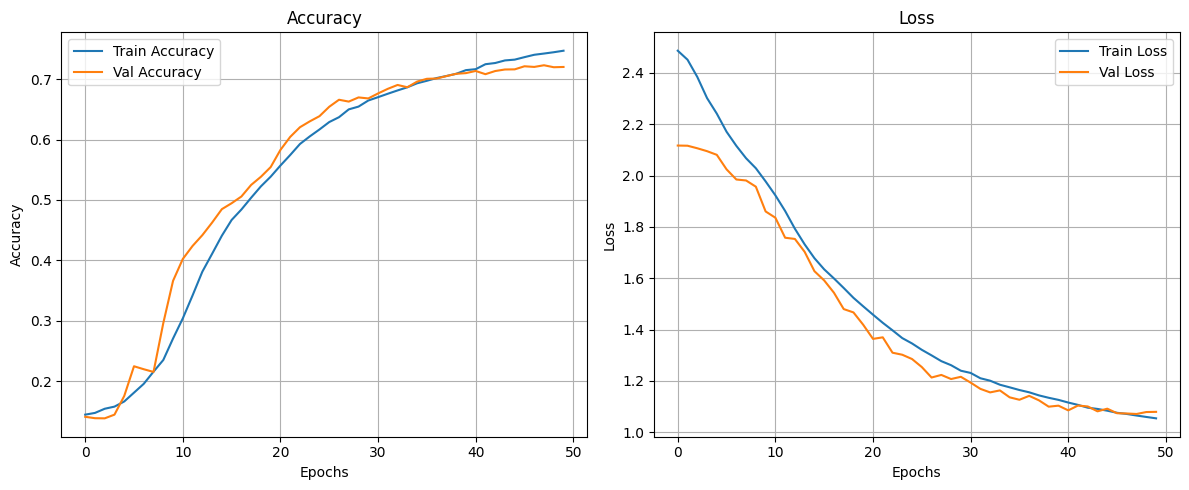

In [78]:
plot_accuracy_and_loss(history)

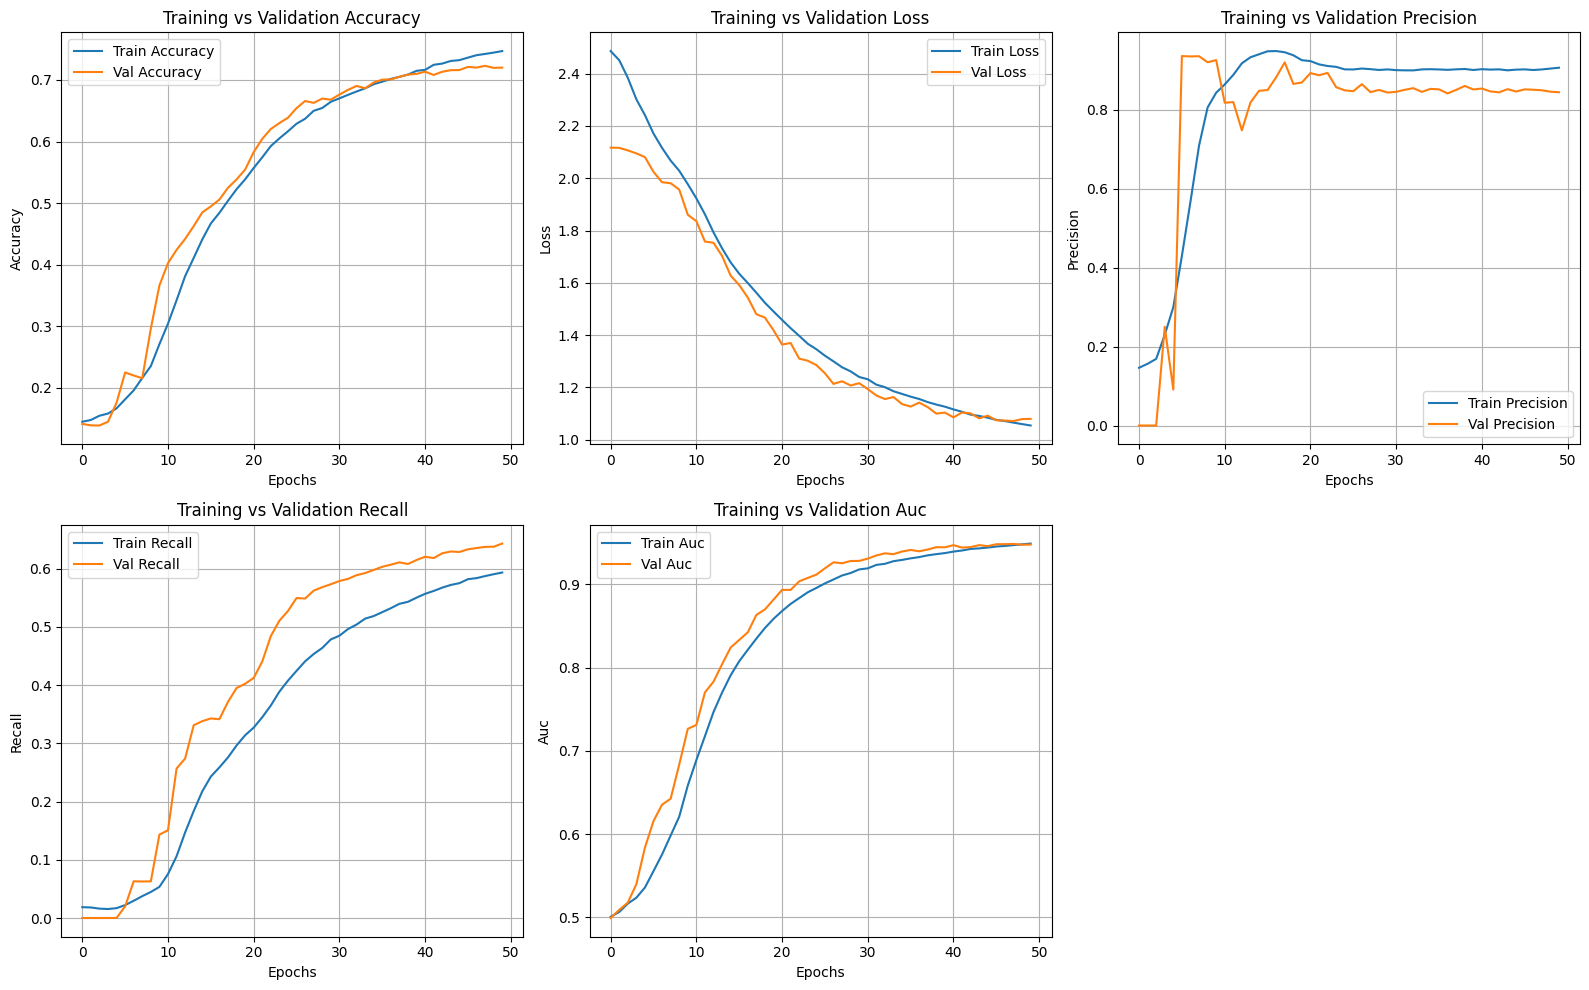

In [79]:
plot_training_metrics(history)

In [80]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import seaborn as sns

In [81]:
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from keras.saving import register_keras_serializable
import tensorflow as tf

@register_keras_serializable()
class WarmUpCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, decay_steps, warmup_steps, alpha=0.0):
        super().__init__()
        self.initial_lr = initial_lr
        self.decay_steps = decay_steps
        self.warmup_steps = warmup_steps
        self.alpha = alpha

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        linear_increase = self.initial_lr * global_step / self.warmup_steps
        cosine_decay = 0.5 * self.initial_lr * (1 + tf.cos(np.pi * (global_step - self.warmup_steps) / (self.decay_steps - self.warmup_steps)))
        decayed = tf.where(global_step < self.warmup_steps, linear_increase, cosine_decay)
        return tf.where(global_step > self.decay_steps, self.alpha * self.initial_lr, decayed)

    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "decay_steps": self.decay_steps,
            "warmup_steps": self.warmup_steps,
            "alpha": self.alpha,
        }

In [225]:
from tensorflow.keras.models import load_model

model = load_model(
    'best_emotion_model.keras',
    custom_objects={'WarmUpCosineDecay': WarmUpCosineDecay}
)
print("Model loaded successfully.")

Model loaded successfully.


In [83]:
label = ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [84]:
def predict_classes_in_batches(model, X_test, label, batch_size=32):
    """
    Predict classes for the test dataset in batches.

    Args:
        model: Trained model.
        X_test: Test dataset of shape (num_samples, 48, 48, 1).
        label: List or dictionary mapping indices to labels.
        batch_size: Number of samples per prediction batch.

    Returns:
        List of predicted class labels.
    """
    # Predict in batches
    predictions = model.predict(X_test, batch_size=batch_size)

    # Decode predictions to class labels
    predicted_classes = [label[np.argmax(pred)] for pred in tqdm(predictions)]
    
    return predicted_classes

In [85]:
from tqdm import tqdm
predicted_classes = predict_classes_in_batches(model, x_test, label)

690/690 ━━━━━━━━━━━━━━━━━━━━ 167s 241ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22073/22073 [00:00<00:00, 514801.50it/s]


In [86]:
batch_size = 32

# 📌 Label mapping
label_map = {'anger': 0,'disgust': 1,'fear': 2,'happy': 3,'neutral': 4,'sad': 5,'surprise': 6}

# 🔁 Reverse map: index → label name
reverse_label_map = {v: k for k, v in label_map.items()}

# Convert one-hot encoded y_test to category indices
category_labels = np.argmax(y_test_oh, axis=1)  # Adding 1 to match the label_map indices

# Map category indices to their string labels
true_classes = [reverse_label_map[label] for label in category_labels]

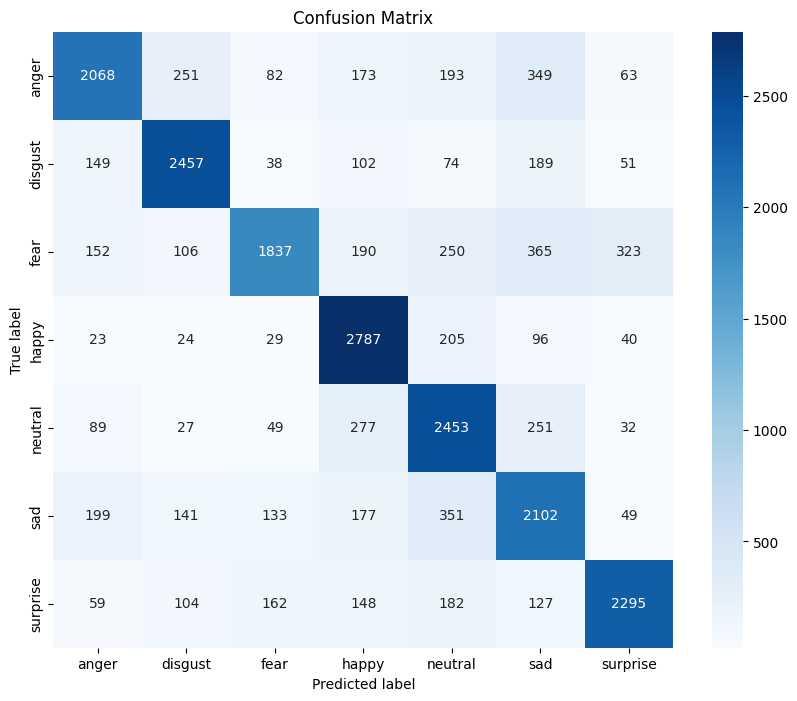

In [87]:
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(true_classes,predicted_classes)

#Plotting with seaborn
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt="d", cmap="Blues",xticklabels=label, yticklabels=label)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [88]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=label)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       anger       0.76      0.65      0.70      3179
     disgust       0.79      0.80      0.80      3060
        fear       0.79      0.57      0.66      3223
       happy       0.72      0.87      0.79      3204
     neutral       0.66      0.77      0.71      3178
         sad       0.60      0.67      0.63      3152
    surprise       0.80      0.75      0.77      3077

    accuracy                           0.72     22073
   macro avg       0.73      0.73      0.72     22073
weighted avg       0.73      0.72      0.72     22073



### Making Prediction ###

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


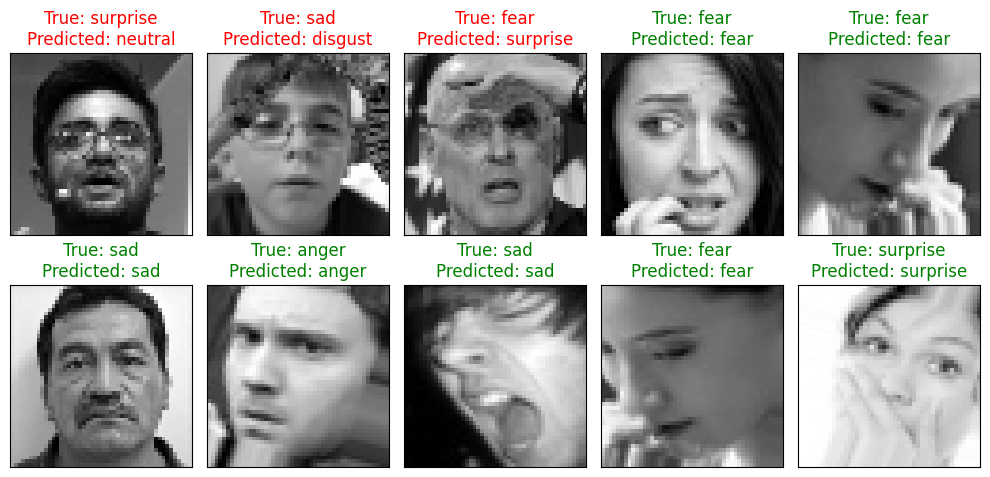

In [170]:
# Setting up the plot
Random_Img_Index = np.random.randint(0, len(x_test)-1,size=10)
fig, axes = plt.subplots(nrows=2,ncols=5,figsize=(10,5),subplot_kw={'xticks':[], 'yticks':[]})
for i,ax in enumerate(axes.flat):
    Random_Img = x_test[Random_Img_Index[i]]
    category_index = np.argmax(y_test_oh[Random_Img_Index[i]])
    Random_Img_Label = reverse_label_map[category_index]
    feature = Random_Img.reshape(1,48,48,1)
    pred = model.predict(feature)
    Model_Prediction = label[pred.argmax()]
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Random_Img_Label == Model_Prediction else "red"
    ax.set_title(f"True: {Random_Img_Label}\nPredicted: {Model_Prediction}", color=color)
plt.tight_layout()
plt.show()

In [230]:
real_data_dir = r'dataset/sample'

In [229]:
Real_Image_Dataset = pd.DataFrame()
Real_Image_Dataset["image"],Real_Image_Dataset["label"] = CreateDataFrame(real_data_dir)

In [201]:
Real_Image_Dataset["label"] = Real_Image_Dataset["label"].map(mood_mapping)

In [202]:
Real_Image_Dataset_features = extract_features(Real_Image_Dataset["image"])
Real_Image_Dataset_labels = Real_Image_Dataset["label"]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 126.28it/s]


In [203]:
y_sample_oh = to_categorical(Real_Image_Dataset_labels, num_classes=7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


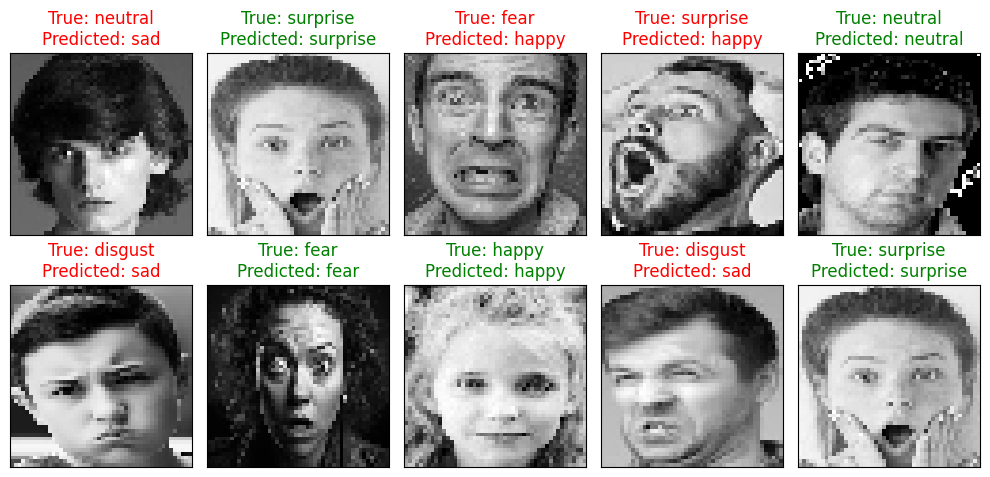

In [207]:
Random_Img_Index = np.random.randint(0, len(Real_Image_Dataset_features)-1,size=10)
fig, axes = plt.subplots(nrows=2,ncols=5,figsize=(10,5),subplot_kw={'xticks':[], 'yticks':[]})
for i,ax in enumerate(axes.flat):
    Random_Img = Real_Image_Dataset_features[Random_Img_Index[i]]
    category_index = np.argmax(y_sample_oh[Random_Img_Index[i]])
    Random_Img_Label = reverse_label_map[category_index]
    feature = Random_Img.reshape(1,48,48,1)
    pred = model.predict(feature)
    Model_Prediction = label[pred.argmax()]
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Random_Img_Label == Model_Prediction else "red"
    ax.set_title(f"True: {Random_Img_Label}\nPredicted: {Model_Prediction}", color=color)
plt.tight_layout()
plt.show()